# Feature Extraction and Visualization with MassDASH

This notebook demonstrates how to extract features from raw DIA data using MassDASH. We will:
- Measure the runtime and memory usage for extraction.
- Display example raw data (FeatureMap DataFrame) for a few precursors.
- Visualize the corresponding feature mask (MS1 and MS2) for selected precursors.
- Evaluate whether these features would serve as useful conditioning signals.

---


## **Step 1: Generating DIA-NN Files**

### **1.1 Downloading and Preparing Raw Data**
- The raw data (human) was obtained from [this dataset](https://www.nature.com/articles/s41467-018-07454-w#Abs1).
- DIA-NN software (latest version) was downloaded from [DIA-NN GitHub](https://github.com/vdemichev/DiaNN/releases/tag/2.0).
- DIA-NN requires **MsFileReader**, which was downloaded from [ProteoWizard](https://proteowizard.sourceforge.io/download.html) as mentioned in the DIA-NN documentation.

### **1.2 Creating the Spectral Library**
- A FASTA file was downloaded to create a spectral library for processing human raw data.
- DIA-NN was configured to **generate precursor ions** using its GUI to obtain the spectral library.

### **1.3 Processing the Raw Data with DIA-NN**
- The spectral library was used to process the raw data.
- **Precursor FDR < 0.01** was applied for filtering.
- The main output files from DIA-NN:
  - `report.parquet` (containing extracted peptide feature information)
  - `gen_lib.parquet` (the generated spectral library from DIA-NN)

---


### Since this report.parquet file was generated using a single test file, the bar plot below will reflect identifications for only this file. Once we process multiple files, we can extend this visualization to show identifications across all samples.

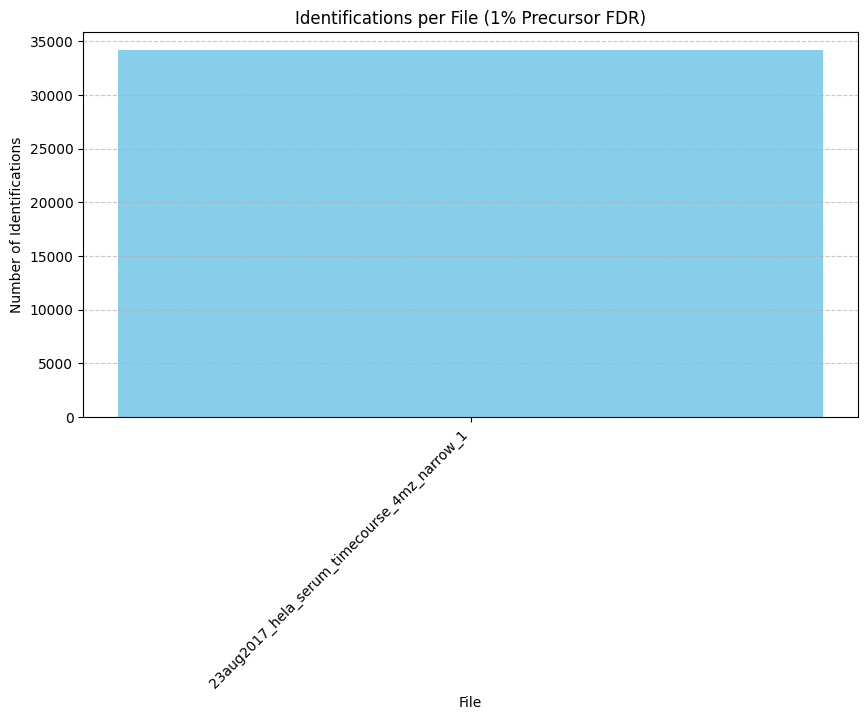

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load DIA-NN output
report_df = pd.read_parquet("report.parquet")

# Filter identifications with Precursor FDR < 1% (Q.Value < 0.01)
filtered_df = report_df[report_df["Q.Value"] < 0.01]

# Count identifications per file
id_counts = filtered_df.groupby("Run").size().reset_index(name="Identifications")

# Plot the number of identifications per file
plt.figure(figsize=(10, 5))
plt.bar(id_counts["Run"], id_counts["Identifications"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("File")
plt.ylabel("Number of Identifications")
plt.title("Identifications per File (1% Precursor FDR)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## **Step 2: Extracting Features Using MassDASH**

MassDASH will be used to re-extract MS1 and MS2 features from the raw data using the outputs from DIA-NN.

### **2.1 Converting DIA-NN Outputs for MassDASH**


In [ ]:
# Convert .parquet files into .tsv for massdash input
import pandas as pd

# ----- Convert report.parquet to TSV -----
report_df = pd.read_parquet("report.parquet")
report_df.to_csv("report.tsv", sep="\t", index=False)
print("Converted report.parquet to report.tsv")

# ----- Convert gen_lib.parquet to TSV -----
gen_lib_df = pd.read_parquet("gen_lib.parquet")
gen_lib_df.to_csv("gen_lib.tsv", sep="\t", index=False)
print("Converted gen_lib.parquet to gen_lib.tsv")

# ----- Modify gen_lib.tsv for MassDASH Input -----
# Read the TSV file
df_gen_lib = pd.read_csv("gen_lib.tsv", sep="\t")

# Rename columns as required by MassDASH
df_gen_lib = df_gen_lib.rename(columns={
    'Precursor.Charge': 'PrecursorCharge',
    'Protein.Ids': 'ProteinId',
    'Stripped.Sequence': 'PeptideSequence',
    'Precursor.Mz': 'PrecursorMz',
    'Modified.Sequence': 'ModifiedPeptideSequence',
    'Relative.Intensity': 'LibraryIntensity',
    'Product.Mz': 'ProductMz',
    'Fragment.Type': 'FragmentType',
    'Fragment.Series.Number': 'FragmentSeriesNumber',
    'Fragment.Charge': 'ProductCharge'  # Assuming this maps to ProductCharge
})

# Save the modified TSV file for MassDASH
df_gen_lib.to_csv("gen_lib_modified.tsv", sep="\t", index=False)
print("Modified gen_lib.tsv and saved as gen_lib_modified.tsv")


Converted report.parquet to report.tsv
Converted gen_lib.parquet to gen_lib.tsv
Modified gen_lib.tsv and saved as gen_lib_modified.tsv


## **Step 3: Loading Data in MassDASH**

In [ ]:
!pip install massdash

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.1/153.1 kB 6.0 MB/s eta 0:00:00
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24864 sha256=cc8d27cde409baa031e1ff4784358786e9874981b0fd958d98693f4560bdba48
  Stored in directory: /root/.cache/pip/wheels/7b/ce/88/1d0bce5b2680165c29c3e68416325e79674d5a9f422d037996
Successfully built upsetplot


In [ ]:
# Initialize Libraries, Logging, and Data Loader
import time
import numpy as np
import cudf  # GPU DataFrame library (RAPIDS)
import logging
import psutil  # For memory usage (optional)

# Suppress excessive FeatureMap warnings
logging.getLogger("FeatureMap").setLevel(logging.ERROR)

# Helper function to print memory usage
def print_memory_usage():
    process = psutil.Process()
    mem = process.memory_info().rss / 1e6  # in MB
    print(f"Current memory usage: {mem:.2f} MB")

print("Libraries loaded.")
print_memory_usage()

# Import MassDASH classes and initialize the loader with your file paths
from massdash.loaders import MzMLDataLoader
from massdash.structs.TargetedDIAConfig import TargetedDIAConfig

# Configure extraction settings
extraction_config = TargetedDIAConfig()
extraction_config.im_window = 0.2    # Ion mobility window (if applicable)
extraction_config.rt_window = 50     # RT window in minutes
extraction_config.mz_tol = 20        # m/z tolerance

# Initialize the data loader with updated file paths
loader = MzMLDataLoader(
    dataFiles="/content/drive/MyDrive/file mzML/23aug2017_hela_serum_timecourse_4mz_narrow_1.mzML",
    rsltsFile="report.tsv",
    libraryFile="gen_lib_modified.tsv"
)

print("Data loader initialized.")
print_memory_usage()


Libraries loaded.
Current memory usage: 809.85 MB
[2025-03-25 04:51:10,891] MzMLDataAccess - INFO - Opening /content/drive/MyDrive/file mzML/23aug2017_hela_serum_timecourse_4mz_narrow_1.mzML file...: Elapsed 23.996625900268555 ms
[2025-03-25 04:51:10,893] MzMLDataAccess - INFO - There are 87362 spectra and 1 chromatograms.
[2025-03-25 04:51:12,214] MzMLDataAccess - INFO - There are 6242 MS1 spectra and 81120 MS2 spectra.
Data loader initialized.
Current memory usage: 1706.16 MB


## **Step 4: Extracting MS1 and MS2 Features**

In [ ]:
#  Load Unique Peptide-Charge Pairs from Report
# (Assuming your report file has already been created as a Parquet file)
report_df = pd.read_parquet("report.parquet")
unique_peptides = report_df[['Modified.Sequence', 'Precursor.Charge']].drop_duplicates()
print(f"Total unique peptides: {len(unique_peptides)}")

# For demonstration, select a small subset (e.g., first 5 peptides)
subset_peptides = unique_peptides.head(5)
subset_peptides


Total unique peptides: 34161


,Modified.Sequence,Precursor.Charge
0,AAAAAAAAAAR,2
1,AAAAAAAAAVSR,2
2,AAAAAAALQAK,2
3,AAAAADLANR,2
4,AAAAC(UniMod:4)LDK,2


In [ ]:
# Process the Subset and Measure Extraction Time and Memory
ms1_results = []
ms2_results = []

start_total = time.time()

# Process each peptide in the subset
for idx, row in subset_peptides.iterrows():
    peptide = row['Modified.Sequence']
    charge = int(row['Precursor.Charge'])
    print(f"\nProcessing peptide: {peptide} (charge {charge})")

    start_pep = time.time()
    try:
        feature_map_collection = loader.loadFeatureMaps(peptide, charge, extraction_config)
    except Exception as e:
        print(f"Error extracting {peptide}: {e}")
        continue
    elapsed_pep = time.time() - start_pep
    print(f"Extraction for {peptide} completed in {elapsed_pep:.2f} seconds")

    # Use the first available run for demonstration
    run_name = list(feature_map_collection.keys())[0]
    feature_map = feature_map_collection[run_name]
    df = feature_map.feature_df.copy()
    df['Peptide'] = peptide
    df['Charge'] = charge
    df['Run'] = run_name

    # Convert to cuDF for GPU processing
    gpu_df = cudf.DataFrame.from_pandas(df)

    # Extract MS1 data (precursor): rows where ms_level == 1 and Annotation == 'prec'
    ms1_gpu = gpu_df[(gpu_df['ms_level'] == 1) & (gpu_df['Annotation'] == 'prec')]
    ms1_gpu = ms1_gpu[['Peptide', 'Charge', 'Run', 'rt', 'precursor_mz', 'int']]
    ms1_gpu = ms1_gpu.rename(columns={'rt': 'RetentionTime',
                                      'precursor_mz': 'Precursor_mz',
                                      'int': 'Intensity'})
    ms1_results.append(ms1_gpu.to_pandas())

    # Extract MS2 data (fragment): rows where ms_level == 2, including precursor m/z
    ms2_gpu = gpu_df[gpu_df['ms_level'] == 2]
    ms2_gpu = ms2_gpu[['Peptide', 'Charge', 'Run', 'rt', 'mz', 'precursor_mz', 'int']]
    ms2_gpu = ms2_gpu.rename(columns={'rt': 'RetentionTime',
                                      'mz': 'Fragment_mz',
                                      'precursor_mz': 'Precursor_mz',
                                      'int': 'Intensity'})
    ms2_results.append(ms2_gpu.to_pandas())

    print_memory_usage()

total_time = time.time() - start_total
print(f"\nTotal extraction time for subset: {total_time:.2f} seconds")



Processing peptide: AAAAAAAAAAR (charge 2)
[2025-03-25 04:51:19,097] MzMLDataAccess - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:51:19,101] MzMLDataAccess - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:51:19,104] MzMLDataAccess - WARNING - MS1 spectrum native id  had no ion mobility array
[2025-03-25 04:51:19,107] MzMLDataAccess - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:51:19,109] MzMLDataAccess - WARNING - MS1 spectrum native id  had no ion mobility array
[2025-03-25 04:51:19,111] MzMLDataAccess - WARNING - MS1 spectrum native id  had no ion mobility array
[2025-03-25 04:51:19,113] MzMLDataAccess - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:51:19,115] MzMLDataAccess - WARNING - MS1 spectrum native id  had no ion mobility array
[2025-03-25 04:51:19,116] MzMLDataAccess - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:51:19,118] MzM

## **Step 5: Combine All Batches and Save Final Files**

In [ ]:
# Combine and Save Subset Results
ms1_df = pd.concat(ms1_results, ignore_index=True)
ms2_df = pd.concat(ms2_results, ignore_index=True)

ms1_df.to_csv("ms1_features_subset.csv", index=False)
ms2_df.to_csv("ms2_features_subset.csv", index=False)

print("Subset MS1 and MS2 features saved to CSV.")


Subset MS1 and MS2 features saved to CSV.


In [ ]:
# Visualize Raw Data and Feature Masks for a Few Precursors

# Display the first few rows of the raw FeatureMap for the first peptide in the subset
first_peptide = subset_peptides.iloc[2]
peptide = first_peptide['Modified.Sequence']
charge = int(first_peptide['Precursor.Charge'])
feature_map_collection = loader.loadFeatureMaps(peptide, charge, extraction_config)
run_name = list(feature_map_collection.keys())[0]
feature_map = feature_map_collection[run_name]
raw_df = feature_map.feature_df
print("Raw FeatureMap Data (first 10 rows):")
print(raw_df.head(10))

# If supported, plot the chromatogram (MS1) for the precursor
transition_group = loader.loadTransitionGroups(peptide, charge, extraction_config)[run_name]
transition_group.plot()  # This should open an interactive plot

# Plot the aggregated MS2 spectra (if supported)
feature_map.to_spectra().plot()


[2025-03-25 04:56:34,863] InteractivePlotter - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:56:34,867] InteractivePlotter - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:56:34,869] InteractivePlotter - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:56:34,872] InteractivePlotter - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:56:34,875] InteractivePlotter - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:56:34,876] InteractivePlotter - WARNING - MS1 spectrum native id  had no ion mobility array
[2025-03-25 04:56:34,879] InteractivePlotter - WARNING - MS1 spectrum native id  had no ion mobility array
[2025-03-25 04:56:34,881] InteractivePlotter - WARNING - MS2 spectrum native id  had no ion mobility array
[2025-03-25 04:56:34,884] InteractivePlotter - WARNING - MS1 spectrum native id  had no ion mobility array
[2025-03-25 04:56:34,886] Interactive

# Conclusions

- **Performance Metrics:**  
  The extraction of a small subset (5 peptides) took approximately 8.62 seconds, and memory usage was reported above.

- **Raw Data vs. Feature Mask:**  
  The raw FeatureMap DataFrame is shown, and interactive plots of the precursor chromatogram (MS1) and aggregated MS2 spectra are generated. This helps assess the quality of the extracted features as conditioning signals.

- **Next Steps:**  
  Once validated on a subset, we can scale the process to the full dataset (e.g., by splitting into batches) and further optimize parameters if needed.
